In [1]:
import torch
torch.manual_seed(0)
ONEHOT=False
DATAPATH = '/home/skrhakv/deeplife/binding-prediction--deeplife-lab/data'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

### use dataset API to load the Yu dataset

In [4]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class YuDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        Xs_list = None
        Ys_list = None
        for key in _Xs.keys():
            if Xs_list is None:
                Xs_list = _Xs[key]
                Ys_list = _Ys[key]
            else:
                Xs_list = np.concatenate((Xs_list,_Xs[key]), axis = 0)
                Ys_list = np.concatenate((Ys_list,_Ys[key]), axis = 0)

        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        if ONEHOT:
            self.Ys = F.one_hot(torch.tensor(Ys_list, dtype=torch.int64))
        else:
            self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


### proccess the Yu dataset

In [5]:
import csv

def proccess_dataset(annotation_path, embeddings_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            
            if id not in Xs:
                filename = id + '.npy'
                embedding = np.load(f'{embeddings_path}/{filename}')
                Xs[id] = embedding

            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for residue_idx in [int(residue[1:]) for residue in row[4].split(' ')]:
                # Yu dataset is 1-based indexing, so we need to subtract 1
                Ys[id][residue_idx - 1] = 1

    return Xs, Ys

In [ ]:
Xs_train, Ys_train = proccess_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/embeddings')

train_dataset = YuDataset(Xs_train, Ys_train)

Xs_test, Ys_test = proccess_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/embeddings')

test_dataset = YuDataset(Xs_test, Ys_test)

In [8]:
print(len(train_dataset))
print(len(test_dataset))

102573
21013


### Define a classifier
Create a classifier to predict whether residue is part of a binding site

In [9]:
from torch import nn

DROPOUT = 0.3
LAYER_WIDTH = 100

class YuClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2560, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout1(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


### Train imbalanced dataset
The dataset is heavily imbalanced (only ~5% of all residues are binding residues, the rest is non-binding), therefore we pass the `weight` argument for the loss function. But first, the weights need to be calculated using the `compute_class_weights(...)` function.

In [10]:
from sklearn.utils import class_weight

def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

torch.manual_seed(42)

In [11]:
from sklearn import metrics  

model_0 = YuClassifier().to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                            lr=0.0001)

X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss = sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

for epoch in range(epochs):
    ### TRAIN
    model_0.train()

    y_logits = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TEST
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")

Epoch: 0 | Loss: 1.74147, Accuracy: 76.38% | Test loss: 0.98904, AUC: 0.5931284432473661, MCC: 0.03957976470712661
Epoch: 10 | Loss: 0.90061, Accuracy: 79.97% | Test loss: 0.56798, AUC: 0.8725090398801749, MCC: 0.33960326584066847
Epoch: 20 | Loss: 0.64754, Accuracy: 86.84% | Test loss: 0.48895, AUC: 0.9081941739440612, MCC: 0.39085549533445313
Epoch: 30 | Loss: 0.52250, Accuracy: 89.61% | Test loss: 0.44746, AUC: 0.9245222177170034, MCC: 0.43235816871229577
Epoch: 40 | Loss: 0.45129, Accuracy: 91.35% | Test loss: 0.42217, AUC: 0.9335375359232239, MCC: 0.4509598131248308
Epoch: 50 | Loss: 0.38658, Accuracy: 92.61% | Test loss: 0.41206, AUC: 0.9386785531774151, MCC: 0.4759166076049038
Epoch: 60 | Loss: 0.34136, Accuracy: 93.39% | Test loss: 0.40654, AUC: 0.9423992073619643, MCC: 0.485183160989474
Epoch: 70 | Loss: 0.29589, Accuracy: 94.18% | Test loss: 0.40896, AUC: 0.944733024667675, MCC: 0.5001573831296198


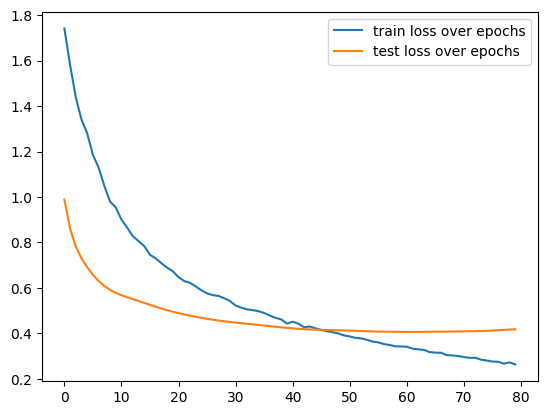

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()

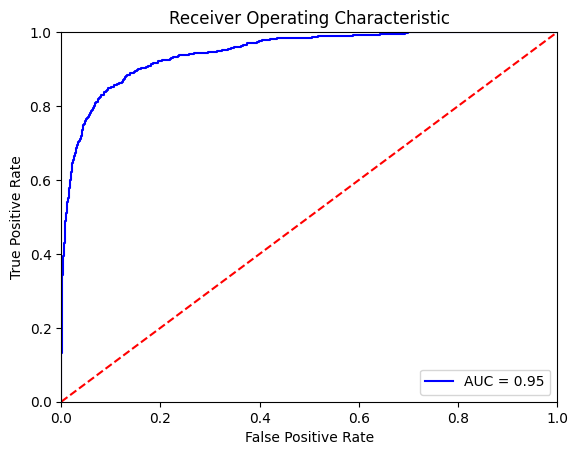

In [13]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Homework: Part 1
Create embeddings based on sequences from the annotation files using a different model (ProtBERT, ProtT5, Ankh?)

In [ ]:
COMPUTE_ANKH_EMBEDDINGS = True

if COMPUTE_ANKH_EMBEDDINGS:
    import ankh
    import torch
    
    model, tokenizer = ankh.load_large_model()
    model.eval()
    
    protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH', 
      'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']
    
    protein_sequences = [list(seq) for seq in protein_sequences]
    
    
    outputs = tokenizer.batch_encode_plus(protein_sequences, 
                                    add_special_tokens=True, 
                                    padding=True, 
                                    is_split_into_words=True, 
                                    return_tensors="pt")
    with torch.no_grad():
        embeddings = model(input_ids=outputs['input_ids'], attention_mask=outputs['attention_mask'])

In [ ]:
if COMPUTE_ANKH_EMBEDDINGS:    
    for seq, i in zip(protein_sequences, embeddings.last_hidden_state.numpy()):
        print(i.shape, len(seq))

(117, 1536) 116
(117, 1536) 80


In [10]:
import numpy as np

def get_sequences(annotation_path):
    sequences = []
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[5]
            sequences.append((id, sequence))

    return sequences

def create_embeddings(sequences, output_path):
    print('Read sequences ...')
    protein_sequences = [list(seq[1]) for seq in sequences]

    outputs = tokenizer.batch_encode_plus(protein_sequences, 
                                    add_special_tokens=True, 
                                    padding=True, 
                                    is_split_into_words=True, 
                                    return_tensors="pt")
    with torch.no_grad():
        print('generate embeddings ...')

        embeddings = model(input_ids=outputs['input_ids'], attention_mask=outputs['attention_mask'])
        print('get embeddings ...')

        embeddings = embeddings.last_hidden_state.numpy()
        print('write embeddings ...')

        assert len(sequences) == embeddings.shape[0]
        for sequence, embedding in zip(sequences, embeddings):
            print(f'process {sequence[0]} ...')

            assert len(sequence) == embedding.shape[0]
            with open(f'{output_path}/{sequence[0]}.npy', 'wb') as f:
                np.save(f, embedding)

In [11]:
if COMPUTE_ANKH_EMBEDDINGS:
    print("reading TRAIN sequences ...")
    train_sequences = get_sequences(f'{DATAPATH}/ADP_Training.txt')
    print("generating TRAIN embeddings ...")
    create_embeddings(train_sequences, f'{DATAPATH}/ankh-embeddings')

print("Processing ...")
Xs_train, Ys_train = proccess_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/ankh-embeddings')
train_dataset = YuDataset(Xs_train, Ys_train)

if COMPUTE_ANKH_EMBEDDINGS:
    print("reading TEST sequences ...")
    test_sequences = get_sequences(f'{DATAPATH}/ADP_Test.txt')
    print("generating TRAIN embeddings ...")
    create_embeddings(test_sequences, f'{DATAPATH}/ankh-embeddings')
    
print("Processing ...")
Xs_test, Ys_test = proccess_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/ankh-embeddings')
test_dataset = YuDataset(Xs_test, Ys_test)

reading TRAIN sequences ...
generating TRAIN embeddings ...
Read sequences ...


generate embeddings ...
get embeddings ...
write embeddings ...
process 2b9hA ...


AssertionError: 

In [6]:
from transformers import BertModel, BertTokenizer
import re
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")
sequence_Example = "A E T C Z A O"
sequence_Example = re.sub(r"[UZOB]", "X", sequence_Example)
encoded_input = tokenizer(sequence_Example, return_tensors='pt')
output = model(**encoded_input)


In [7]:
output.last_hidden_state.detach().numpy().shape


(1, 9, 1024)

In [15]:
protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH', 
      'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']

protein_sequences = [seq.replace("", " ")[1: -1] for seq in protein_sequences]
output = []
for seq in protein_sequences:
    encoded_input = tokenizer(seq, return_tensors='pt')
    output.append(model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1])

In [16]:
for i in output:
    print(i.shape)

(116, 1024)
(80, 1024)


In [20]:
import numpy as np

def get_sequences(annotation_path):
    sequences = []
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[5]
            sequences.append((id, sequence))

    return sequences

def create_embeddings(sequences, output_path):    
    with torch.no_grad():
        for sequence in sequences:
            print(f'Process {sequence[0]} ...')
            encoded_input = tokenizer(sequence[1].replace("", " ")[1: -1], return_tensors='pt')
            embedding = model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1]

            assert len(sequence[1]) == embedding.shape[0]
            with open(f'{output_path}/{sequence[0]}.npy', 'wb') as f:
                np.save(f, embedding)

In [21]:
print("reading TRAIN sequences ...")
train_sequences = get_sequences(f'{DATAPATH}/ADP_Training.txt')
print("generating TRAIN embeddings ...")
create_embeddings(train_sequences, f'{DATAPATH}/ankh-embeddings')

print("Processing ...")
Xs_train, Ys_train = proccess_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/ankh-embeddings')
train_dataset = YuDataset(Xs_train, Ys_train)

print("reading TEST sequences ...")
test_sequences = get_sequences(f'{DATAPATH}/ADP_Test.txt')
print("generating TRAIN embeddings ...")
create_embeddings(test_sequences, f'{DATAPATH}/ankh-embeddings')
    
print("Processing ...")
Xs_test, Ys_test = proccess_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/ankh-embeddings')
test_dataset = YuDataset(Xs_test, Ys_test)

reading TRAIN sequences ...
generating TRAIN embeddings ...
Process 2b9hA ...
Process 2fnaA ...
Process 1hi5A ...
Process 3kjiA ...
Process 1k3cA ...
Process 3llmA ...
Process 1nvaA ...
Process 1pkgA ...
Process 3nbxX ...
Process 3ko5A ...
Process 1fwkA ...
Process 2dcnA ...
Process 2axnA ...
Process 3g2fA ...
Process 1cnfA ...
Process 2awnA ...
Process 2qb5A ...
Process 2rd5A ...
Process 1r0yA ...
Process 1gzfC ...
Process 3dzvA ...
Process 1t6xA ...
Process 1iqpA ...
Process 2ch6A ...
Process 1e3mA ...
Process 3k1jA ...
Process 3hz6A ...
Process 1y63A ...
Process 1e4eA ...
Process 3ec2A ...
Process 1rfvA ...
Process 1z59A ...
Process 3i73A ...
Process 1a9xA ...
Process 1a9xA ...
Process 1xtjA ...
Process 1qf9A ...
Process 2qr1B ...
Process 1jj7A ...
Process 1b62A ...
Process 3akkA ...
Process 1tzdA ...
Process 2hehA ...
Process 3ouzA ...
Process 2a2cA ...
Process 3bfvA ...
Process 1r6bX ...
Process 1ao0A ...
Process 1ao0A ...
Process 1xjkA ...
Process 3pnlB ...
Process 3fwyA ...
Proc

In [22]:
np.load(f'{DATAPATH}/ankh-embeddings/2b9hA.npy').shape

(337, 1024)

In [23]:
np.load(f'{DATAPATH}/ankh-embeddings/2fnaA.npy').shape

(352, 1024)

In [24]:
len(get_sequences(f'{DATAPATH}/ADP_Training.txt') + get_sequences(f'{DATAPATH}/ADP_Test.txt'))


367